In [9]:
!pip install pyspark
!pip install prophet

In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, dayofweek, avg
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.functions import to_timestamp, date_format
from prophet import Prophet

In [11]:
spark = SparkSession.builder \
    .appName("Traffic Pattern Analysis") \
    .getOrCreate()

In [12]:
df = spark.read.csv("hdfs:///traffic_data/Metro_Interstate_Traffic_Volume.csv", header=True, inferSchema=True)


In [13]:
df

DataFrame[holiday: string, temp: double, rain_1h: double, snow_1h: double, clouds_all: int, weather_main: string, weather_description: string, date_time: timestamp, traffic_volume: int]

In [14]:
df = df.withColumn("hour", hour("date_time"))
df = df.withColumn("day_of_week", dayofweek("date_time"))

In [15]:
df

DataFrame[holiday: string, temp: double, rain_1h: double, snow_1h: double, clouds_all: int, weather_main: string, weather_description: string, date_time: timestamp, traffic_volume: int, hour: int, day_of_week: int]

In [16]:
df.groupBy("hour").avg("traffic_volume").orderBy("hour").show()

+----+-------------------+
|hour|avg(traffic_volume)|
+----+-------------------+
|   0|  834.7810505645557|
|   1|   516.448999511957|
|   2| 388.35364041604754|
|   3|  371.0908641975309|
|   4|  702.5518890483022|
|   5|  2094.573436742608|
|   6|  4140.503593675132|
|   7|  4740.181337181337|
|   8|  4587.497115384615|
|   9|  4385.277502477701|
|  10|  4184.665543792108|
|  11| 4465.8775614754095|
|  12|  4718.293094629156|
|  13|  4714.940682414698|
|  14|  4931.888776028441|
|  15|   5240.52430196484|
|  16|  5663.756539235413|
|  17|  5310.076047594413|
|  18|  4263.718529707956|
|  19|   3276.39418663947|
+----+-------------------+
only showing top 20 rows



In [17]:
df.groupBy("day_of_week").avg("traffic_volume").orderBy("day_of_week").show()

+-----------+-------------------+
|day_of_week|avg(traffic_volume)|
+-----------+-------------------+
|          1|  2368.588329452852|
|          2|  3309.387160633484|
|          3|  3488.555799006719|
|          4|  3583.196681096681|
|          5| 3637.8996626081853|
|          6| 3656.3588355763604|
|          7| 2773.6381203337723|
+-----------+-------------------+



In [18]:
df.groupBy("weather_main").avg("traffic_volume").orderBy("avg(traffic_volume)", ascending=False).show()


+------------+-------------------+
|weather_main|avg(traffic_volume)|
+------------+-------------------+
|      Clouds|  3618.449749406489|
|        Haze| 3502.1014705882353|
|        Rain| 3317.9055007052184|
|     Drizzle|  3290.727073036793|
|       Smoke|            3237.65|
|       Clear|  3055.908819356284|
|        Snow|  3016.844228094576|
|Thunderstorm| 3001.6208897485494|
|        Mist|  2932.956638655462|
|         Fog|  2703.720394736842|
|      Squall|            2061.75|
+------------+-------------------+



In [19]:
sns.set(style="whitegrid")

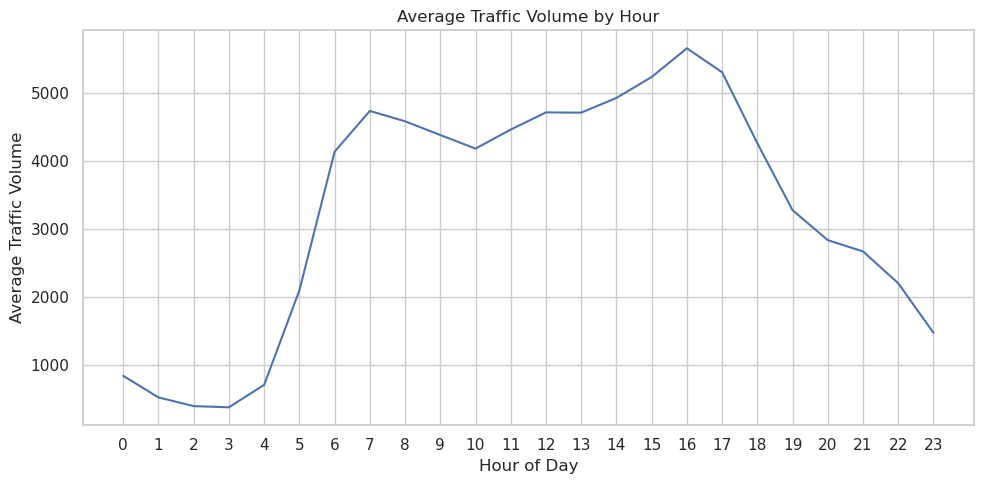

In [20]:
hourly_df = df.groupBy("hour").avg("traffic_volume").orderBy("hour").toPandas()
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_df, x="hour", y="avg(traffic_volume)")
plt.title("Average Traffic Volume by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Traffic Volume")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig("traffic_by_hour.png")
plt.show()

/tmp/ipykernel_17084/1062619200.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_df, x="day_of_week", y="avg(traffic_volume)", palette="viridis")


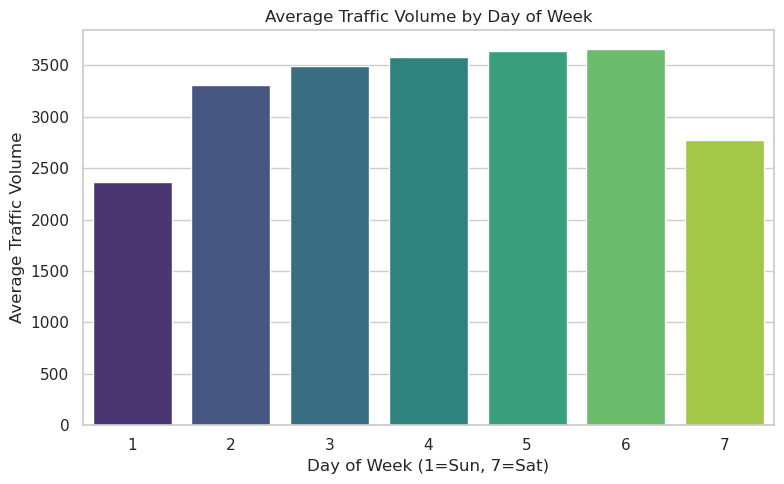

In [21]:
dow_df = df.groupBy("day_of_week").avg("traffic_volume").orderBy("day_of_week").toPandas()
plt.figure(figsize=(8, 5))
sns.barplot(data=dow_df, x="day_of_week", y="avg(traffic_volume)", palette="viridis")
plt.title("Average Traffic Volume by Day of Week")
plt.xlabel("Day of Week (1=Sun, 7=Sat)")
plt.ylabel("Average Traffic Volume")
plt.tight_layout()
plt.savefig("traffic_by_day.png")
plt.show()

/tmp/ipykernel_17084/433022048.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=weather_df, x="weather_main", y="avg(traffic_volume)", palette="coolwarm")


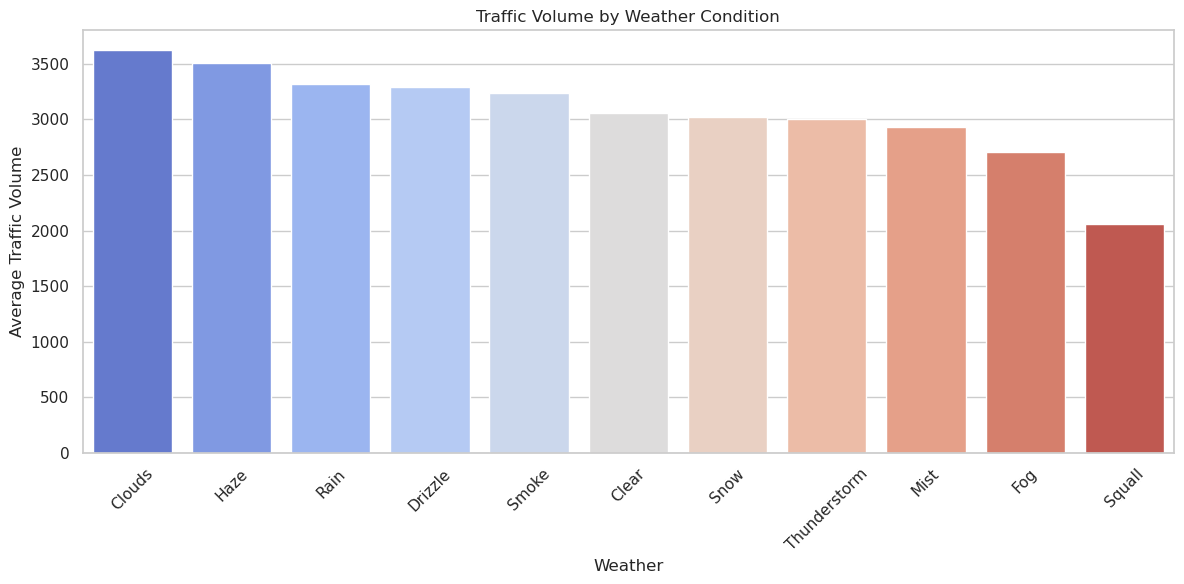

In [22]:
weather_df = df.groupBy("weather_main").avg("traffic_volume").orderBy("avg(traffic_volume)", ascending=False).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=weather_df, x="weather_main", y="avg(traffic_volume)", palette="coolwarm")
plt.title("Traffic Volume by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Average Traffic Volume")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("traffic_by_weather.png")
plt.show()

## Anomaly Detection 

We'll use some time-series anomaly detection algorithm to find the recurring anomalies , 

Since the data is in Spark but anomaly detection tools are better in Python (Pandas/Numpy/Statsmodels/Prophet), we'll follow this pipeline:

 Aggregate traffic volume over time 

Collect to Pandas DataFrame

 Use a time-series anomaly detection algorithm
 
Visualize anomalies

In [23]:
# Convert date_time to hourly timestamp (truncate to hour)
df = df.withColumn("timestamp", date_format("date_time", "yyyy-MM-dd HH:00:00"))

# Group by timestamp (hourly)
ts_df = df.groupBy("timestamp").avg("traffic_volume").orderBy("timestamp")

# Convert to Pandas
pandas_df = ts_df.toPandas()
pandas_df['timestamp'] = pd.to_datetime(pandas_df['timestamp'])
pandas_df = pandas_df.rename(columns={'avg(traffic_volume)': 'traffic_volume'})
pandas_df = pandas_df.set_index('timestamp').sort_index()

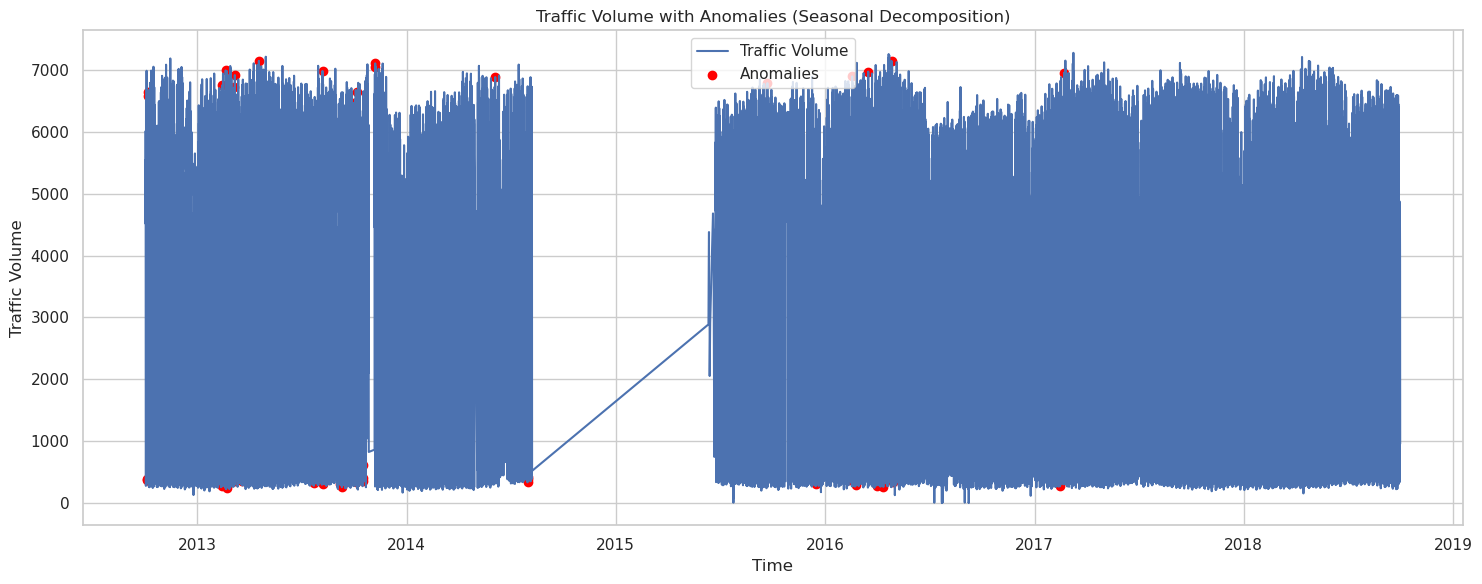

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Fill any missing values
pandas_df['traffic_volume'] = pandas_df['traffic_volume'].interpolate()

# Decompose
decomposition = seasonal_decompose(pandas_df['traffic_volume'], model='additive', period=24)
residual = decomposition.resid

# Set threshold for anomalies (e.g. 2 standard deviations)
threshold = 2 * residual.std()
anomalies = residual[(residual > threshold) | (residual < -threshold)]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(pandas_df.index, pandas_df['traffic_volume'], label='Traffic Volume')
plt.scatter(anomalies.index, pandas_df.loc[anomalies.index]['traffic_volume'], color='red', label='Anomalies')
plt.title("Traffic Volume with Anomalies (Seasonal Decomposition)")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.legend()
plt.tight_layout()
plt.savefig("anomalies_decomposition.png")
plt.show()


DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbhk9m5v/u76xdw43.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbhk9m5v/tovn7fac.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15982', 'data', 'file=/tmp/tmpnbhk9m5v/u76xdw43.json', 'init=/tmp/tmpnbhk9m5v/tovn7fac.json', 'output', 'file=/tmp/tmpnbhk9m5v/prophet_modeljzl2lwh2/prophet_model-20250522160334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:03:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:03:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


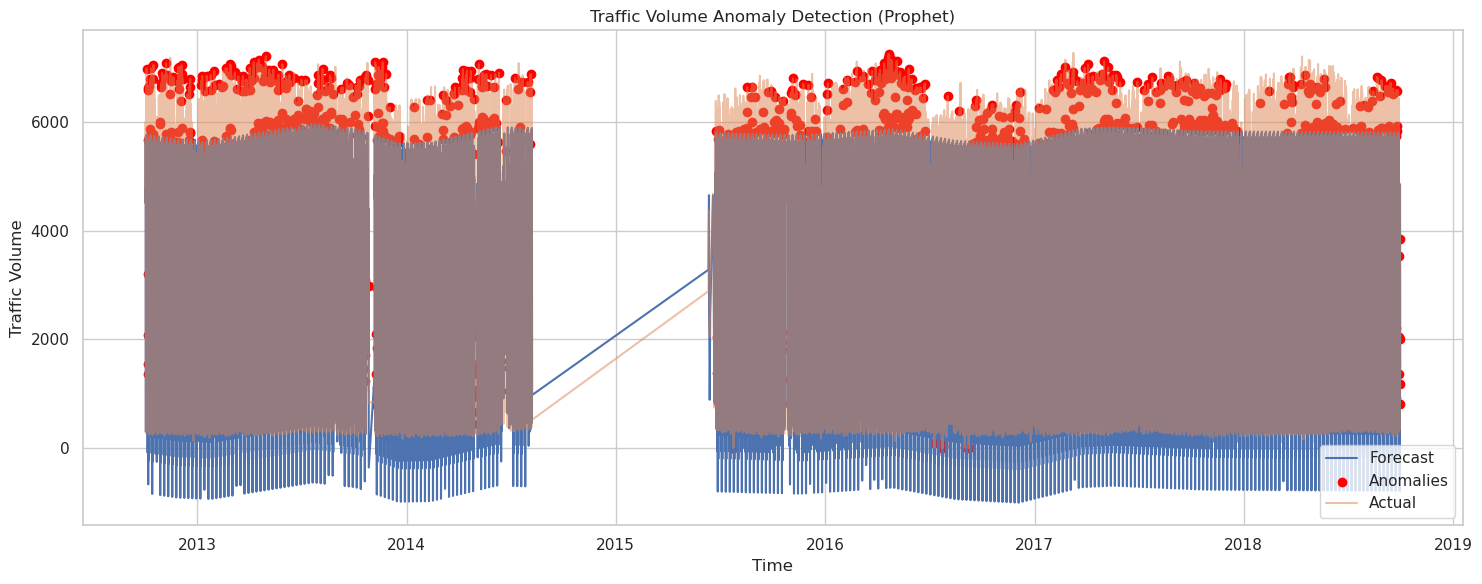

In [25]:


# Prepare for Prophet
prophet_df = pandas_df.reset_index().rename(columns={'timestamp': 'ds', 'traffic_volume': 'y'})

# Fit model
model = Prophet(daily_seasonality=True, yearly_seasonality=False)
model.fit(prophet_df)

# Predict
future = model.make_future_dataframe(periods=0, freq='H')
forecast = model.predict(future)

# Add residual and threshold
forecast['residual'] = prophet_df['y'] - forecast['yhat']
std_dev = forecast['residual'].std()
forecast['anomaly'] = (forecast['residual'].abs() > 2 * std_dev)

# Plot anomalies
plt.figure(figsize=(15, 6))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast')
plt.scatter(forecast[forecast['anomaly']]['ds'],
            prophet_df[forecast['anomaly']]['y'], color='red', label='Anomalies')
plt.plot(forecast['ds'], prophet_df['y'], alpha=0.5, label='Actual')
plt.legend()
plt.title("Traffic Volume Anomaly Detection (Prophet)")
plt.xlabel("Time")
plt.ylabel("Traffic Volume")
plt.tight_layout()
plt.savefig("anomalies_prophet.png")
plt.show()


In [26]:
from pyspark.sql.functions import date_trunc
import pandas as pd

# Truncate to hour for merging
df = df.withColumn("hour", date_trunc("hour", "date_time"))

# Select only necessary columns
context_df = df.select("hour", "weather_main", "temp").dropDuplicates()
context_pd = context_df.toPandas().rename(columns={"hour": "ds"})

# Merge with forecast
merged = forecast.merge(context_pd, on="ds", how="left")
anomalies = merged[merged["anomaly"]]

# Display most common weather during anomalies
print("Common weather types during anomalies:")
print(anomalies["weather_main"].value_counts())

# Show temp extremes
print("Temperature range during anomalies:")
print(anomalies["temp"].describe())


Common weather types during anomalies:
weather_main
Clouds          987
Clear           911
Mist            626
Rain            324
Snow            243
Fog             161
Drizzle         111
Haze             83
Thunderstorm     71
Smoke             2
Name: count, dtype: int64
Temperature range during anomalies:
count    3519.000000
mean      278.317935
std        14.479733
min         0.000000
25%       270.490000
50%       278.660000
75%       288.815000
max       310.070000
Name: temp, dtype: float64


/tmp/ipykernel_17084/1110709460.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=anomalies, x="weather_main", order=anomalies["weather_main"].value_counts().index, palette="Set2")
/tmp/ipykernel_17084/1110709460.py:7: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


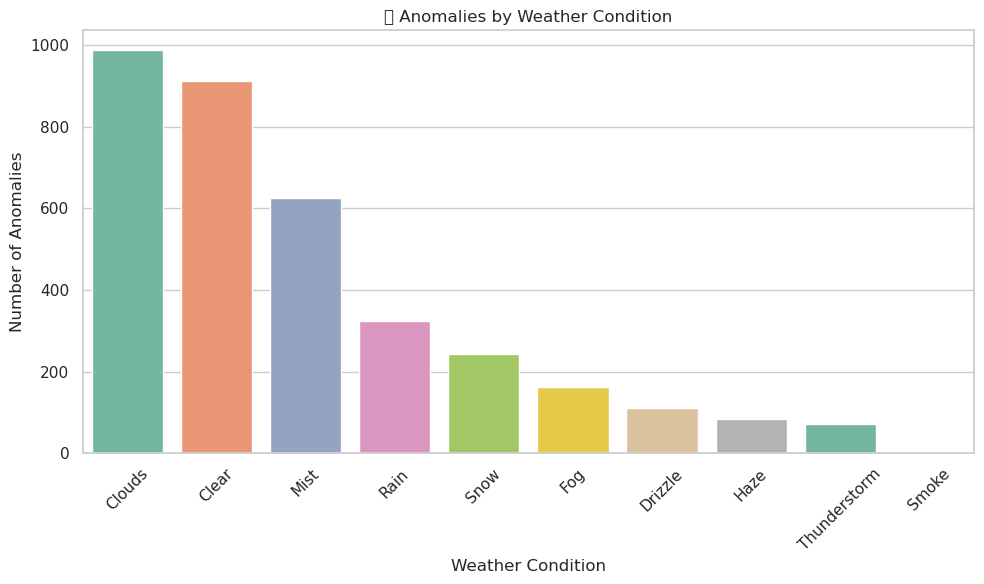

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(data=anomalies, x="weather_main", order=anomalies["weather_main"].value_counts().index, palette="Set2")
plt.title("🚨 Anomalies by Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_17084/3496998495.py:6: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127777 (\N{THERMOMETER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


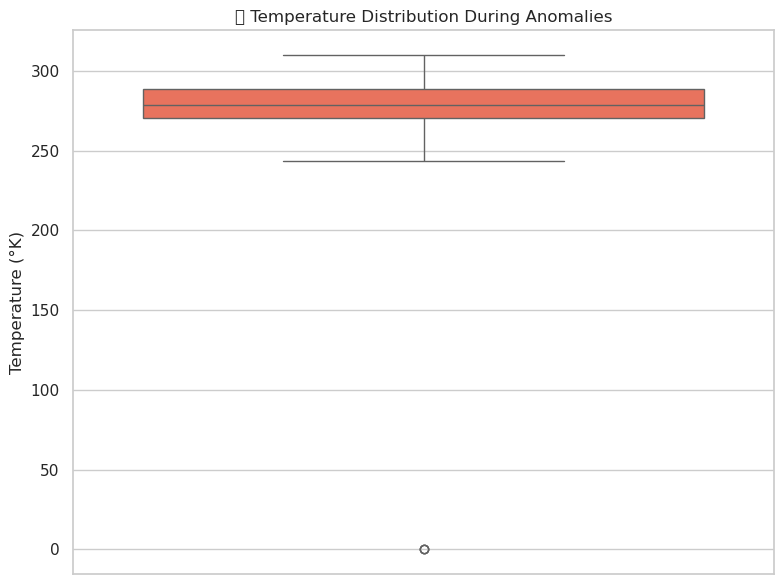

In [28]:
# Box plot for temperature during anomalies
plt.figure(figsize=(8, 6))
sns.boxplot(data=anomalies, y="temp", color="tomato")
plt.title("🌡️ Temperature Distribution During Anomalies")
plt.ylabel("Temperature (°K)")
plt.tight_layout()
plt.show()


In [29]:
anomalies.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'residual', 'anomaly',
       'weather_main', 'temp'],
      dtype='object')

/tmp/ipykernel_17084/3460759047.py:21: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.savefig("traffic_volume_forecast.png")
/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


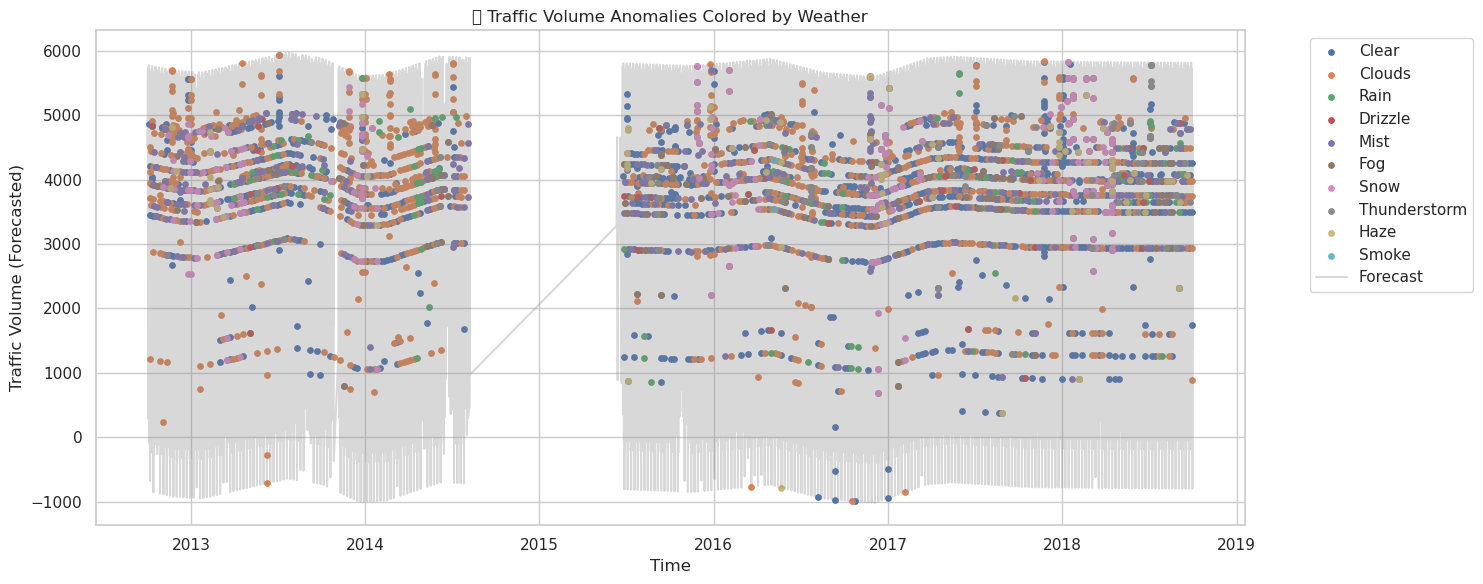

In [41]:
import matplotlib.pyplot as plt

# Drop rows with missing values in key columns
anomalies = anomalies.dropna(subset=["ds", "yhat", "weather_main"])

# Plot setup
plt.figure(figsize=(15, 6))

# Plot each weather condition with its own color
for condition in anomalies['weather_main'].unique():
    subset = anomalies[anomalies['weather_main'] == condition]
    plt.scatter(subset['ds'], subset['yhat'], label=condition, s=15)

# Plot the actual full forecast line (optional)
plt.plot(merged['ds'], merged['yhat'], alpha=0.3, label="Forecast", color="gray")

# Chart details
plt.title("🚗 Traffic Volume Anomalies Colored by Weather")
plt.xlabel("Time")
plt.ylabel("Traffic Volume (Forecasted)")
plt.savefig("traffic_volume_forecast.png")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [31]:

subset = anomalies.sample(n=500, random_state=42)
subset = anomalies[(anomalies['ds'] >= '2016-01-01') & (anomalies['ds'] <= '2016-03-01')]
top_conditions = anomalies['weather_main'].value_counts().nlargest(3).index
subset = anomalies[anomalies['weather_main'].isin(top_conditions)]

/tmp/ipykernel_17084/2504178730.py:19: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


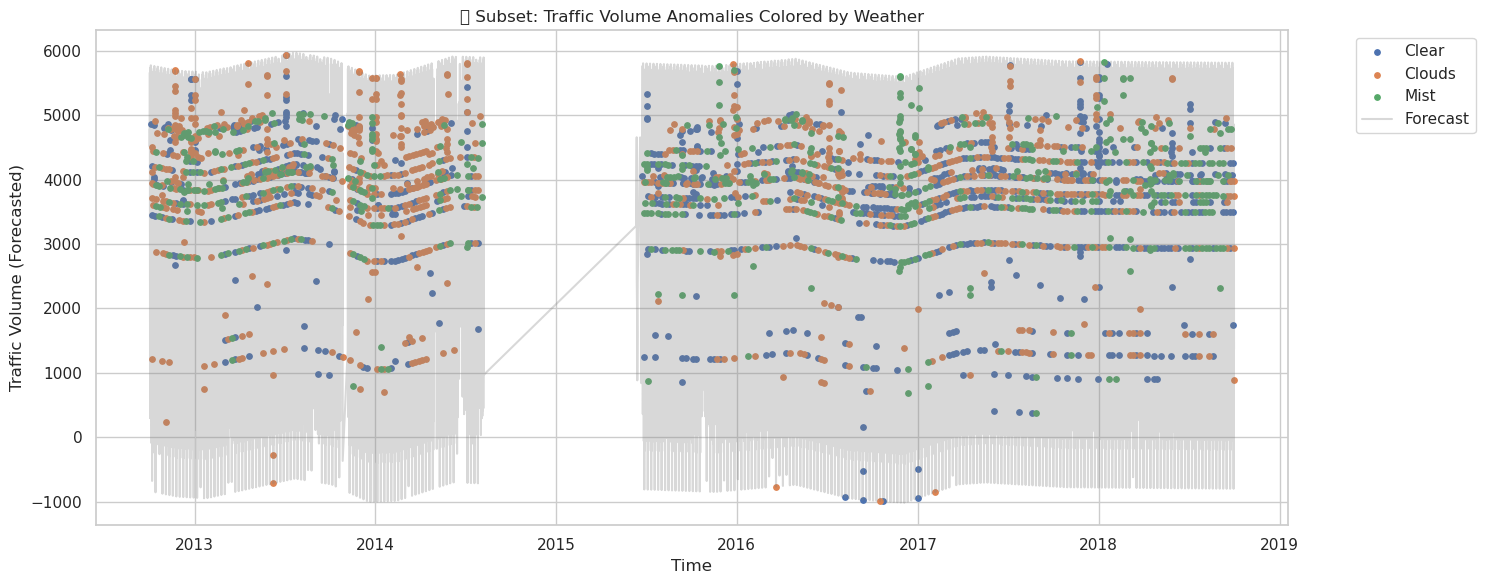

In [32]:
import matplotlib.pyplot as plt

# Drop rows with missing values in key columns
subset = subset.dropna(subset=["ds", "yhat", "weather_main"])

# Plot
plt.figure(figsize=(15, 6))

for condition in subset['weather_main'].unique():
    cond_subset = subset[subset['weather_main'] == condition]
    plt.scatter(cond_subset['ds'], cond_subset['yhat'], label=condition, s=15)

plt.plot(merged['ds'], merged['yhat'], alpha=0.3, label="Forecast", color="gray")

plt.title("🚗 Subset: Traffic Volume Anomalies Colored by Weather")
plt.xlabel("Time")
plt.ylabel("Traffic Volume (Forecasted)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Holiday & Event Impact Analysis

In [38]:
anomalies_pd = anomalies[['ds', 'yhat']].copy()
anomalies_pd = anomalies_pd.rename(columns={'yhat': 'y'})


In [39]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

# Create holiday DataFrame
holidays = make_holidays_df(year_list=[2015, 2016, 2017, 2018, 2019], country='US')

# Initialize and fit Prophet model
model = Prophet(holidays=holidays)
model.fit(anomalies_pd)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbhk9m5v/6ycvj0di.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpnbhk9m5v/wx_k_8gq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/home/praneeth-yeddu/anaconda3/lib/python3.12/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69325', 'data', 'file=/tmp/tmpnbhk9m5v/6ycvj0di.json', 'init=/tmp/tmpnbhk9m5v/wx_k_8gq.json', 'output', 'file=/tmp/tmpnbhk9m5v/prophet_models5d5c3rz/prophet_model-20250522160841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:08:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


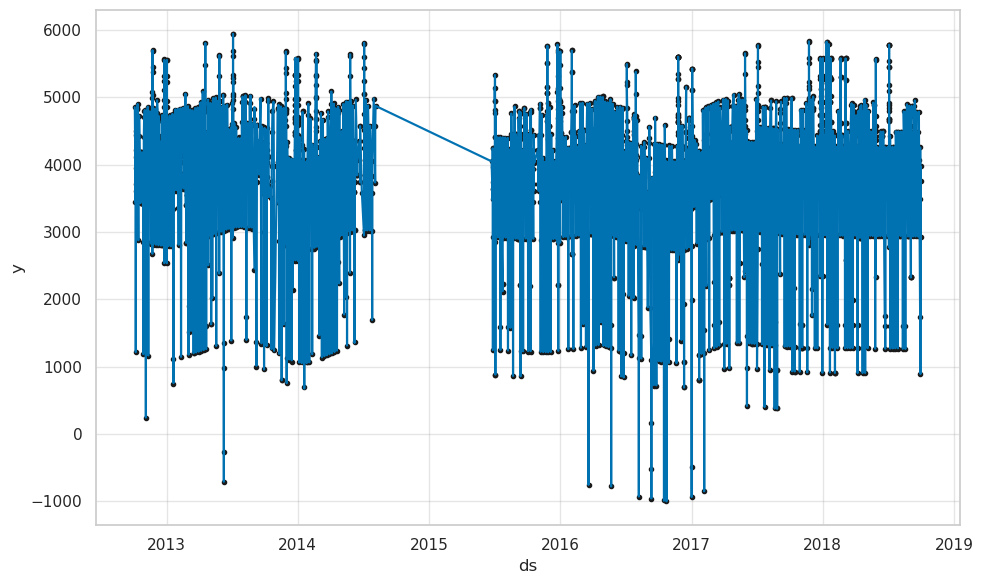

In [40]:
# Make future dataframe and predictions
future = model.make_future_dataframe(periods=0)  # Only in-sample fit
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)


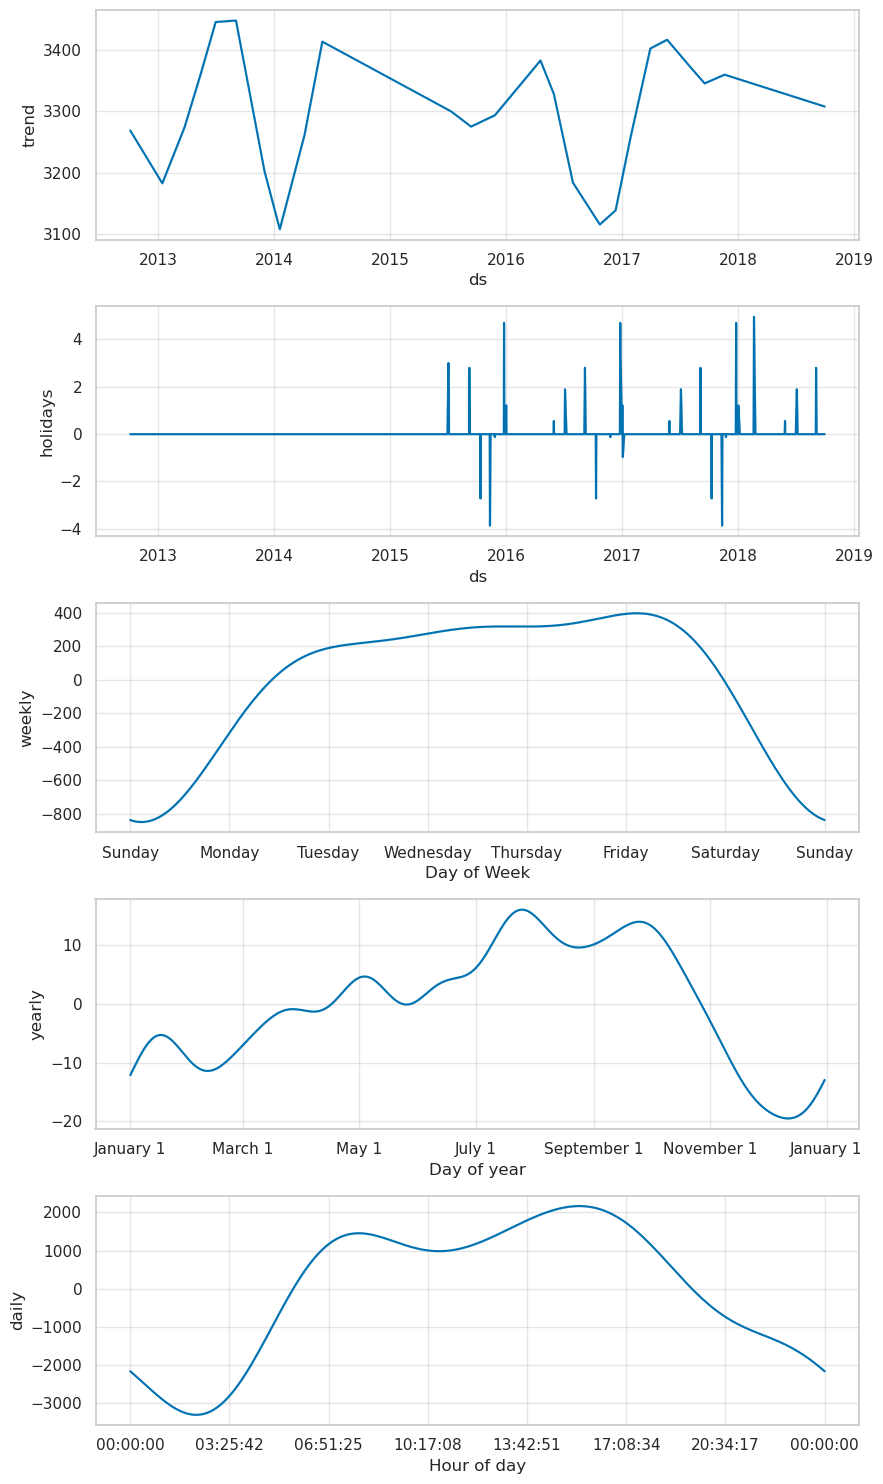

In [42]:
# Plot trend + holiday effects + seasonality components
fig2 = model.plot_components(forecast)


/tmp/ipykernel_17084/3409276788.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_17084/3409276788.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("actual_vs_forecasted.png")


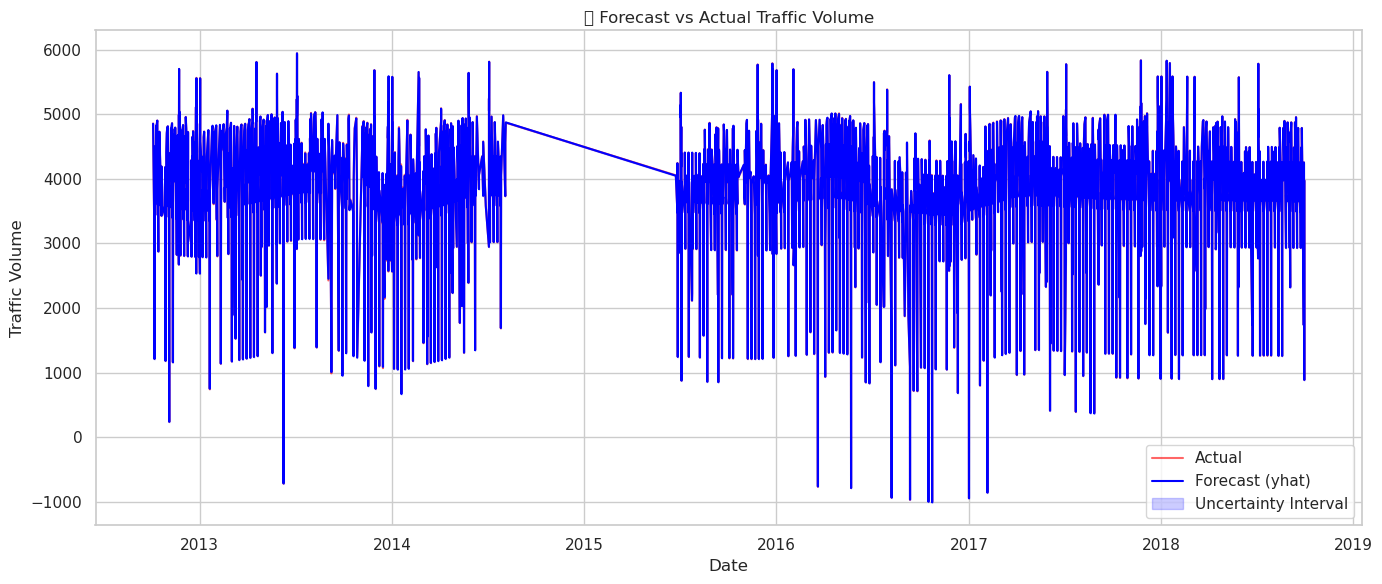

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(anomalies_pd['ds'], anomalies_pd['y'], label='Actual', color='red', alpha=0.6)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (yhat)', color='blue')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='blue', alpha=0.2, label='Uncertainty Interval')
plt.title('📈 Forecast vs Actual Traffic Volume')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.savefig("actual_vs_forecasted.png")
plt.show()


/tmp/ipykernel_17084/3408165089.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


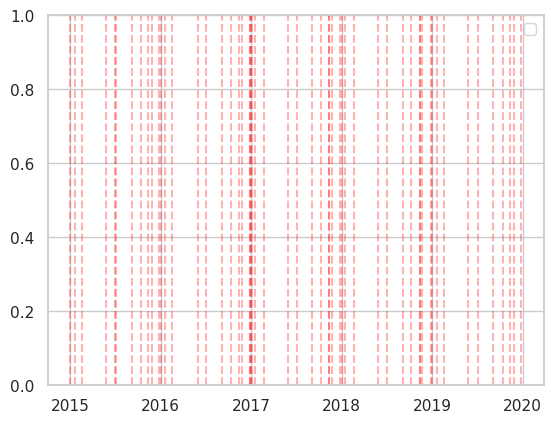

In [46]:
us_holidays = make_holidays_df(year_list=[2015, 2016, 2017, 2018, 2019], country='US')

for date in us_holidays['ds']:
    plt.axvline(date, color='red', linestyle='--', alpha=0.3)

plt.legend()


## Weather Traffic Interaction Modelling 

In [73]:
df2=anomalies.copy()
df2.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'residual', 'anomaly',
       'weather_main', 'temp'],
      dtype='object')

In [74]:
# Convert date
df2['ds'] = pd.to_datetime(df2['ds'])

# Time features
df2['hour'] = df2['ds'].dt.hour
df2['day_of_week'] = df2['ds'].dt.dayofweek
df2['is_weekend'] = df2['day_of_week'].isin([5, 6]).astype(int)
df2['month'] = df2['ds'].dt.month
df2['is_rush_hour'] = df2['hour'].isin([7, 8, 9, 16, 17, 18]).astype(int)

# Rename
df2.rename(columns={'yhat': 'traffic_volume'}, inplace=True)

# One-hot encode weather
df2 = pd.get_dummies(df2, columns=['weather_main'], drop_first=True)

# Final feature list
df2 = df2[['traffic_volume', 'hour', 'day_of_week', 'is_weekend', 'month',
           'is_rush_hour', 'temp'] + [col for col in df2.columns if 'weather_main_' in col]]


In [76]:
df2.columns

Index(['traffic_volume', 'hour', 'day_of_week', 'is_weekend', 'month',
       'is_rush_hour', 'temp', 'weather_main_Clouds', 'weather_main_Drizzle',
       'weather_main_Fog', 'weather_main_Haze', 'weather_main_Mist',
       'weather_main_Rain', 'weather_main_Smoke', 'weather_main_Snow',
       'weather_main_Thunderstorm'],
      dtype='object')

In [80]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df2.drop('traffic_volume', axis=1)
y = df2['traffic_volume']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("R² Score:", r2_score(y_test, y_pred))


R² Score: 0.9939435123460052


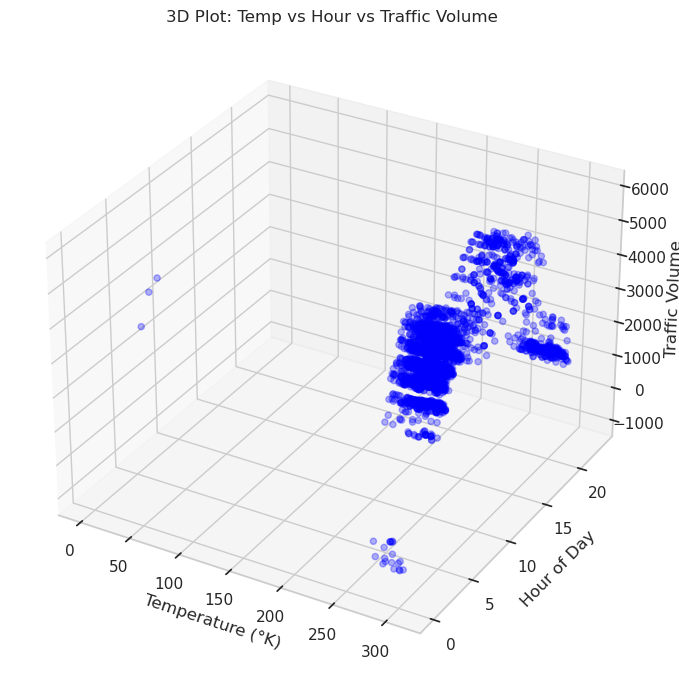

In [83]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter plot
ax.scatter(df2['temp'], df2['hour'], df2['traffic_volume'], alpha=0.3, c='blue')

ax.set_xlabel('Temperature (°K)')
ax.set_ylabel('Hour of Day')
ax.set_zlabel('Traffic Volume')
plt.title('3D Plot: Temp vs Hour vs Traffic Volume')
plt.tight_layout()
plt.show()
